# Optimal POVM

One can open this tutorial in Google Colab (is recommended)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LuchnikovI/QGOpt/blob/master/docs/source/optimal_povm.ipynb)

In the following tutorial, we show how to perform optimization over the manifold of POVMs by using the QGOpt library. It is known that measurements of a qubit induced by tetrahedral POVM allow reconstructing an unknown qubit state with a minimal variance if there is no prior information about a qubit state. Let us check this fact numerically using optimization over the manifold of POVMs.
In the beginning, let us import some libraries.

In [1]:
import tensorflow as tf  # tf 2.x
import matplotlib.pyplot as plt
import math

try:
    import QGOpt as qgo
except ImportError:
    !pip install git+https://github.com/LuchnikovI/QGOpt@Dev
    import QGOpt as qgo

# Fix random seed to make results reproducable.
tf.random.set_seed(42)

## 1. Prior information about a quantum state

We represent a prior probability distribution over a quantum state approximately, by using a set of samples from a prior distribution. Since tetrahedral POVM is optimal when there is no prior information about a state, we consider uniform distribution across the Bloch ball.

In [2]:
#-------------------------------------------------------------------------#
num_of_samples = 10000  # number of samples representing prior information
#-------------------------------------------------------------------------#

# Pauli matrices
sigma_x = tf.constant([[0, 1], [1, 0]], dtype=tf.complex128)
sigma_y = tf.constant([[0 + 0j, -1j], [1j, 0 + 0j]], dtype=tf.complex128)
sigma_z = tf.constant([[1, 0], [0, -1]], dtype=tf.complex128)

# All Pauli matrices in one tensor of shape (3, 2, 2)
sigma = tf.concat([sigma_x[tf.newaxis],
                   sigma_y[tf.newaxis],
                   sigma_z[tf.newaxis]], axis=0)

# Set of points distributed uniformly across Bloch ball
x = tf.random.normal((num_of_samples, 3), dtype=tf.float64)
x = x / tf.linalg.norm(x, axis=-1, keepdims=True)
x = tf.cast(x, dtype=tf.complex128)
u = tf.random.uniform((num_of_samples, 1), maxval=1, dtype=tf.float64)
u = u ** (1 / 3)
u = tf.cast(u, dtype=tf.complex128)
x = x * u

# Set of density matrices distributed uniformly across Bloch ball
# (prior information)
rho = 0.5 * (tf.eye(2, dtype=tf.complex128) + tf.tensordot(x, sigma, axes=1))

## 2. Search for the optimal POVM with given prior information about a state

Here we search for the optimal POVM via minimizing the variance of a posterior distribution over density matrices. First, we define an example of the POVMs manifold:

In [3]:
m = qgo.manifolds.POVM()

The manifolds of POVMs is represented through the quadratic parametrization $M_i = A_iA_i^\dagger$ with an equivalence relation $A_i\sim A_iQ_i$, where $Q_i$ is an arbitrary unitary matrix. Here, we initialize a variable that represents the parametrization of each element of POVM:

In [4]:
# randon initial parametrization of POVM
A = m.random((4, 2, 2), dtype=tf.complex128)
# real representtion of A
A = qgo.manifolds.complex_to_real(A)
# tf.Variable to be tuned
A = tf.Variable(A)

Then we initialize Riemannian Adam optimizer:

In [5]:
lr = 0.03
opt = qgo.optimizers.RAdam(m, lr)

Finally, we ran the part of code that calculates forward pass, gradients, and optimization step several times until convergence to the optimal point is reached:

In [6]:
for i in range(1000):
    with tf.GradientTape() as tape:

        # Complex representation of A
        Ac = qgo.manifolds.real_to_complex(A)
        # POVM from its parametrization
        povm = Ac @ tf.linalg.adjoint(Ac)
        # Inverce POVM (is needed to map a probability distribution to a density matrix)
        povm_inv = tf.linalg.inv(tf.reshape(povm, (4, 4)))
        # Matrix T maps probability vector to four real parameters representing
        # a quantum state (equivalent to inverse POVM)
        T = tf.concat([tf.math.real(povm_inv[0, tf.newaxis]),
                        tf.math.real(povm_inv[3, tf.newaxis]),
                        tf.math.real(povm_inv[2, tf.newaxis]),
                        tf.math.imag(povm_inv[2, tf.newaxis])], axis=0)

        # POVM maps a quantum state to a probability vector
        p = tf.tensordot(rho, povm, axes=[[2], [1]])
        p = tf.transpose(p, (0, 2, 1, 3))
        p = tf.math.real(tf.linalg.trace(p))

        # Covariance matrix of a reconstructed density matrix
        cov = -p[:, tf.newaxis] * p[..., tf.newaxis]
        cov = cov + tf.linalg.diag(p ** 2)
        cov = cov + tf.linalg.diag(p * (1 - p))
        cov = tf.tensordot(T, cov, [[1], [1]])
        cov = tf.tensordot(cov, T, [[2], [1]])
        cov = tf.transpose(cov, (1, 0, 2))

        # Covariance matrix avaraged over prior distribution
        av_cov = tf.reduce_mean(cov, axis=0)

        # loss function (log volume of Covariance matrix)
        loss = tf.reduce_sum(tf.math.log(tf.linalg.svd(av_cov)[0][:-1]))
    grad = tape.gradient(loss, A)  # gradient
    opt.apply_gradients(zip([grad], [A]))  # minimization step

## 3. Verification

Here we check the resulting optimal POVM. For tetrahedral POVM one has the following relation ${\rm Tr}\left(M^\alpha M^\beta\right) = \frac{2\delta_{\alpha\beta} + 1}{12}$. One can see, that this relation is almost true for a resulting POVM. The small error appears due to the approximate Monte-Carlo averaging of a covariance matric by using a set of samples from the prior distribution.

tf.Tensor(
[[0.24927765 0.08337808 0.08333673 0.08328467]
 [0.08337808 0.24939711 0.08328523 0.08333633]
 [0.08333673 0.08328523 0.25029829 0.08337795]
 [0.08328467 0.08333633 0.08337795 0.25102899]], shape=(4, 4), dtype=float64)


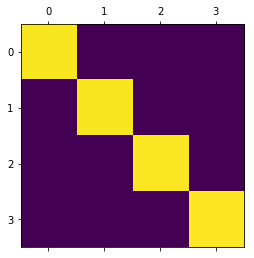

In [7]:
cross = tf.tensordot(povm, povm, [[2], [1]])
cross = tf.transpose(cross, (0, 2, 1, 3))
cross = tf.linalg.trace(cross)
cross = tf.math.real(cross)
plt.matshow(cross)
print(cross)